In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transaction_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')


train_df = pd.read_csv('/kaggle/working/traindf_processed.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   id            int64  
 2   date          object 
 3   store_nbr     int64  
 4   family        object 
 5   sales         float64
 6   onpromotion   int64  
 7   city          object 
 8   state         object 
 9   type          object 
 10  cluster       int64  
 11  dcoilwtico    float64
 12  holiday_type  object 
 13  locale        object 
 14  locale_name   object 
 15  description   object 
 16  transferred   object 
dtypes: float64(2), int64(5), object(10)
memory usage: 396.1+ MB


# Missing Values Detection

In [4]:
train_df.isnull().sum()

Unnamed: 0            0
id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [5]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


train_df.describe()

,Unnamed: 0,id,store_nbr,sales,onpromotion,cluster,dcoilwtico
count,3054348.00000,3054348.00000,3054348.00000,3054348.00000,3054348.00000,3054348.00000,2099196.00000
mean,1527173.50000,1504276.77538,27.50000,359.02089,2.61748,8.48148,68.01587
std,881714.46434,866261.01201,15.58579,1107.28590,12.25494,4.64973,25.69134
min,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,26.19000
25%,763586.75000,754676.75000,14.00000,0.00000,0.00000,4.00000,46.41000
50%,1527173.50000,1507571.50000,27.50000,11.00000,0.00000,8.50000,53.43000
75%,2290760.25000,2255120.25000,41.00000,196.01100,0.00000,13.00000,95.81000
max,3054347.00000,3000887.00000,54.00000,124717.00000,741.00000,17.00000,110.62000


In [6]:
#percentage of missing values in train_df 

missing_percentages = train_df.isnull().sum()/ len(train_df) * 100 

print(missing_percentages)

Unnamed: 0      0.00000
id              0.00000
date            0.00000
store_nbr       0.00000
family          0.00000
sales           0.00000
onpromotion     0.00000
city            0.00000
state           0.00000
type            0.00000
cluster         0.00000
dcoilwtico     31.27188
holiday_type   83.54726
locale         83.54726
locale_name    83.54726
description    83.54726
transferred    83.54726
dtype: float64


In [7]:
# remove columns that are having more than 30% missing values

columns_to_delete = missing_percentages[missing_percentages > 40].index

train_df = train_df.drop(columns=columns_to_delete)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unnamed: 0   int64  
 1   id           int64  
 2   date         object 
 3   store_nbr    int64  
 4   family       object 
 5   sales        float64
 6   onpromotion  int64  
 7   city         object 
 8   state        object 
 9   type         object 
 10  cluster      int64  
 11  dcoilwtico   float64
dtypes: float64(2), int64(5), object(5)
memory usage: 279.6+ MB


# Duplicates

In [9]:
train_df.duplicated().any()

False

In [10]:
dupes=train_df.duplicated()

#dupes
sum(dupes)

0

In [11]:
#dropping duplicate values

train_df = train_df.drop_duplicates()
train_df

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0,Quito,Pichincha,D,13,NaN
1,1,1,2013-01-01,1,BABY CARE,0.00000,0,Quito,Pichincha,D,13,NaN
2,2,2,2013-01-01,1,BEAUTY,0.00000,0,Quito,Pichincha,D,13,NaN
3,3,3,2013-01-01,1,BEVERAGES,0.00000,0,Quito,Pichincha,D,13,NaN
4,4,4,2013-01-01,1,BOOKS,0.00000,0,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3054343,3000883,2017-08-15,9,POULTRY,438.13300,0,Quito,Pichincha,B,6,47.57000
3054344,3054344,3000884,2017-08-15,9,PREPARED FOODS,154.55300,1,Quito,Pichincha,B,6,47.57000
3054345,3054345,3000885,2017-08-15,9,PRODUCE,2419.72900,148,Quito,Pichincha,B,6,47.57000
3054346,3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00000,8,Quito,Pichincha,B,6,47.57000


In [12]:
train_df.duplicated().any()

False

In [13]:
test_df.duplicated().any()

False

# Check for missing values

In [14]:
train_df.isnull().sum()

Unnamed: 0          0
id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type                0
cluster             0
dcoilwtico     955152
dtype: int64

In [15]:
train_df.describe()

,Unnamed: 0,id,store_nbr,sales,onpromotion,cluster,dcoilwtico
count,3054348.00000,3054348.00000,3054348.00000,3054348.00000,3054348.00000,3054348.00000,2099196.00000
mean,1527173.50000,1504276.77538,27.50000,359.02089,2.61748,8.48148,68.01587
std,881714.46434,866261.01201,15.58579,1107.28590,12.25494,4.64973,25.69134
min,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,26.19000
25%,763586.75000,754676.75000,14.00000,0.00000,0.00000,4.00000,46.41000
50%,1527173.50000,1507571.50000,27.50000,11.00000,0.00000,8.50000,53.43000
75%,2290760.25000,2255120.25000,41.00000,196.01100,0.00000,13.00000,95.81000
max,3054347.00000,3000887.00000,54.00000,124717.00000,741.00000,17.00000,110.62000


# The dataset for dcoilwtico exhibits missing values. According to the provided plot, a suitable approach for addressing this issue would be to employ the backwards fill method.

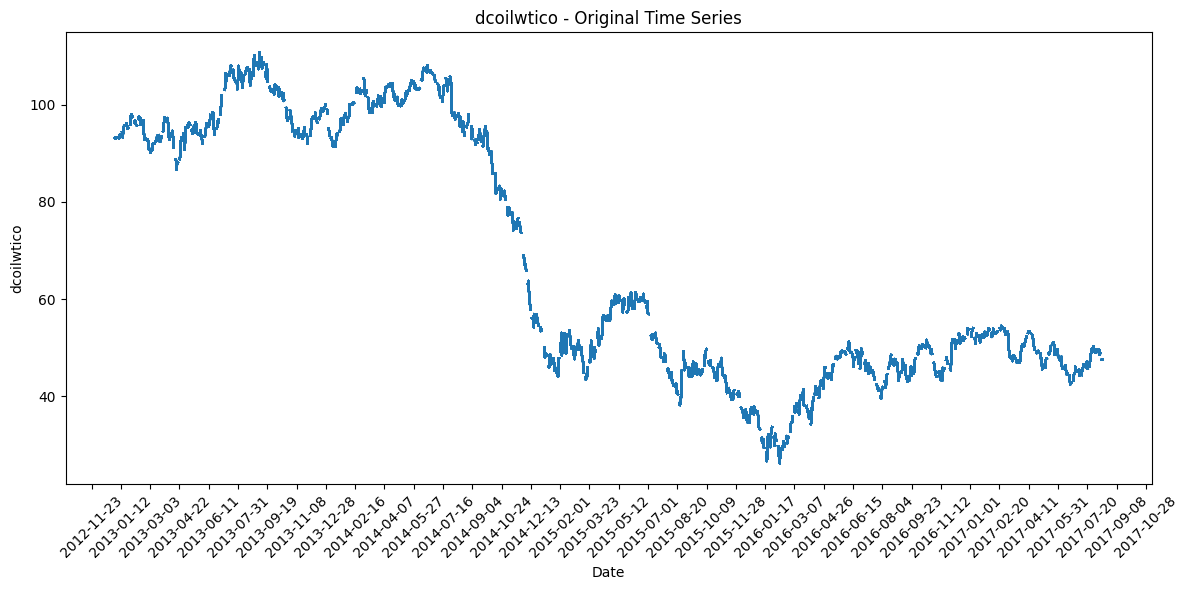

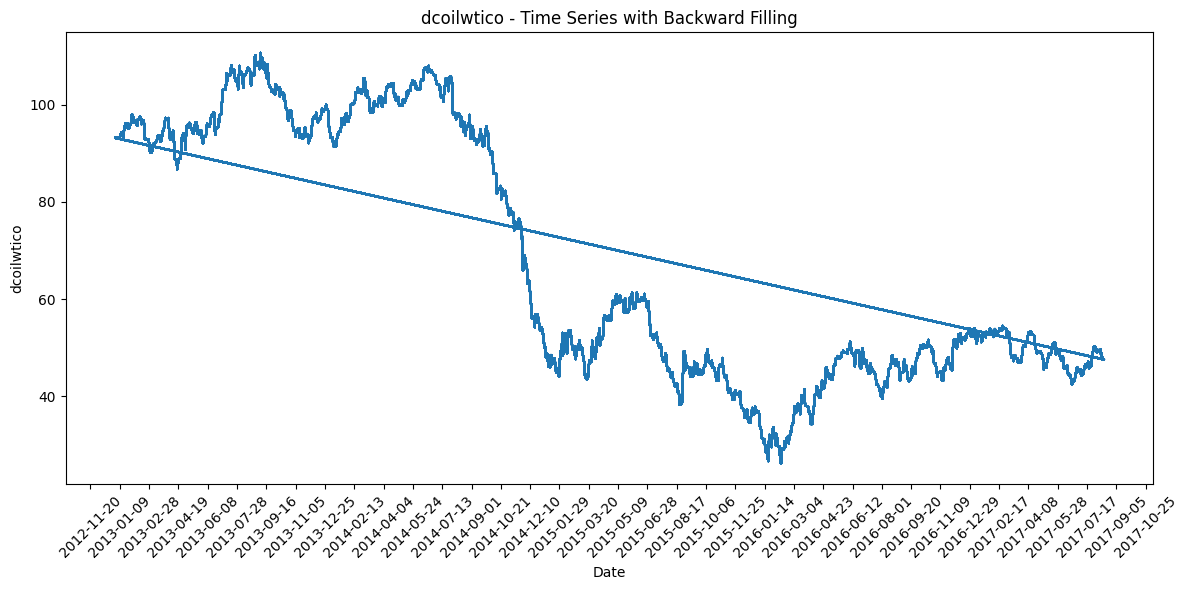

In [20]:
import matplotlib.dates as mdates

# Assuming you have loaded the DataFrame as 'train_df'

# Convert the 'date' column to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Plotting the original time series
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['dcoilwtico'])
plt.title('dcoilwtico - Original Time Series')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.xticks(rotation=45)

# Format x-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))  # Adjust the interval as needed

plt.tight_layout()
plt.show()

# Filling missing values with bfill
train_df['dcoilwtico_filled'] = train_df['dcoilwtico'].fillna(method='bfill')

# Plotting the filled time series
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['dcoilwtico_filled'])
plt.title('dcoilwtico - Time Series with Backward Filling')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.xticks(rotation=45)

# Format x-axis ticks
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))  # Adjust the interval as needed

plt.tight_layout()
plt.show()

In [ ]:
train_df.to_csv('traindf_preprocessed.csv')
